In [5]:
%matplotlib widget
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from src.setup_OptiProblem import setup_OptiProblem
plt.style.use('ggplot')
plt.close("all")

df = pd.read_parquet("data/sym_data/sym_df_5s_res_withPower.parquet")
df = df["2023-05-23 20:00:00":"2023-05-24 08:00:00"]

In [6]:
zs = 2
N = 24
Ts = 5
mpc_controller = setup_OptiProblem(N,zs,Ts)

In [7]:
# =================== History Initialization ===================
# ==== Last element[-1]: latest; first[0]: oldest
h_hist = df["level"][0:zs].values
w_hist = np.vstack([df["pump1_speed"][0:zs].values,df["pump3_speed"][0:zs].values,df["pump4_speed"][0:zs].values]).reshape(3,-1)
Qout_hist = df["outflow"][0:zs].values
E_hist = np.vstack([df["pump1_power_est"][0:zs].values,df["pump3_power_est"][0:zs].values,df["pump4_power_est"][0:zs].values]).reshape(3,-1)
P_hist = df["pressure"][0:zs].values
effi_hist = [0,0]
Qin_hist = df["inflow"][0:zs].values


# construct pump trigger signal based on external schedule
trigger_k = np.zeros((3,10000))
trigger_k[0,:4300] = 1
trigger_k[1,4200:] = 1
# trigger_k[2,2600:] = 1

# sine load:
# cycles = 2 # how many sine cycles
# resolution = 2100 # how many datapoints to generate
# length = np.pi * 2 * cycles
# Qin_k = np.sin(np.arange(0, length, length / resolution))*1200+1200

Qin_k = df["inflow"].values

# building some trajectory for height reference
# h_ref_k = np.hstack([[150,150,150],np.arange(150, 145, (149-150)/(N+zs)), np.ones(10000)*145]) 
h_ref_k = np.ones(10000)*120
h_ref_hist = h_ref_k[0:zs] # history of reference for plotting, href_k cant be plotted because time horizon 

In [8]:
# =================== Measurement Updates and appending ===================
for k in range(8000):
    print(f"iteration : {k}")

    # Actual Solving
    sol_w,sol_Qout,sol_h,sol_E,sol_P,sol_effi = mpc_controller(Qin_k[k+zs],Qout_hist[-zs:],h_hist[-zs:],w_hist[:,-zs:],E_hist[:,-zs:],P_hist[-zs:],trigger_k[:,k+zs],h_ref_k[k:N+k+zs])
        
    h_meas_k = sol_h[zs].full().reshape(1)
    h_hist = np.hstack([h_hist, h_meas_k])

    w_meas_k = sol_w[:,zs].full()
    w_hist = np.hstack([w_hist, w_meas_k])

    Qout_meas_k = sol_Qout[zs].full().reshape(1)
    Qout_hist = np.hstack([Qout_hist, Qout_meas_k])  

    E_meas_k = sol_E[:,zs].full()
    E_hist = np.hstack([E_hist, E_meas_k])   

    P_meas_k = sol_P[zs].full().reshape(-1)
    P_hist = np.hstack([P_hist, P_meas_k]) 

    effi_k = sol_effi[zs].full().reshape(-1)
    effi_hist = np.hstack([effi_hist, effi_k])   

    h_ref_hist = np.hstack([h_ref_hist, h_ref_k[k+zs]])   
    
    Qin_hist = np.hstack([Qin_hist, Qin_k[k+zs]])   


iteration : 0
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   3.39ms (169.65us) 448.50us ( 22.42us)        20
       nlp_g  |   8.20ms (409.90us)   1.16ms ( 57.84us)        20
  nlp_grad_f  |   5.18ms (258.85us) 720.80us ( 36.04us)        20
  nlp_hess_l  |   4.00ms (222.50us) 520.30us ( 28.91us)        18
   nlp_jac_g  |  16.70ms (835.00us)   2.31ms (115.34us)        20
       total  |   2.26 s (  2.26 s) 287.53ms (287.53ms)         1
iteration : 1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   7.57ms (189.25us) 936.00us ( 23.40us)        40
       nlp_g  |  17.76ms (443.98us)   2.39ms ( 59.67us)        40
    nlp_grad  | 907.00us (907.00us) 113.30us (113.30us)         1
  nlp_grad_f  |  13.28ms (332.03us)   1.56ms ( 39.11us)        40
  nlp_hess_l  |   8.29ms (230.28us)   1.07ms ( 29.74us)        36
   nlp_jac_g  |  26.76ms (669.02us)   3.69ms ( 92.36us)        40
       total  |   2.40 s (  2.40 s) 304.68ms (30

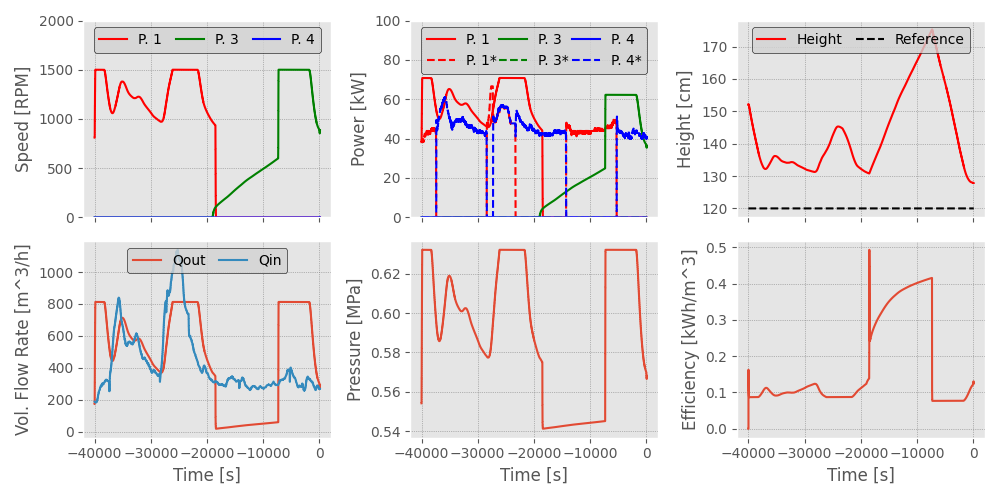

In [9]:
time = np.arange((-h_hist.shape[0]+2)*Ts, (N+1)*Ts,Ts)
fig, axs = plt.subplots(2, 3, figsize=(10, 5), sharex=True, sharey=False)

# Plot 1 - Speed [RPM]
axs[0, 0].step(time,np.hstack([w_hist[0, :],sol_w[0,zs+1:].full().reshape(-1)]), "r", label='P. 1',where='post')
axs[0, 0].step(time,np.hstack([w_hist[1, :],sol_w[1,zs+1:].full().reshape(-1)]), "g", label='P. 3',where='post')
axs[0, 0].step(time,np.hstack([w_hist[2, :],sol_w[2,zs+1:].full().reshape(-1)]), "b", label='P. 4',where='post')
axs[0, 0].set_ylim([0, 2000])
axs[0, 0].set_ylabel('Speed [RPM]')
axs[0, 0].grid(linestyle=':', linewidth='0.5', color='gray')
axs[0, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')


# Plot 2 - Power [kW]
axs[0, 1].step(time,np.hstack([E_hist[0, :],sol_E[0,zs+1:].full().reshape(-1)]), "r", label='P. 1',where='post')
axs[0, 1].step(time,df["pump1_power_est"][:k+N+zs].values, "r--", label='P. 1*',where='post')
axs[0, 1].step(time,np.hstack([E_hist[1, :],sol_E[1,zs+1:].full().reshape(-1)]), "g", label='P. 3',where='post')
axs[0, 1].step(time,df["pump3_power_est"][:k+N+zs].values, "g--", label='P. 3*',where='post')
axs[0, 1].step(time,np.hstack([E_hist[2, :],sol_E[2,zs+1:].full().reshape(-1)]), "b", label='P. 4',where='post')
axs[0, 1].step(time,df["pump4_power_est"][:k+N+zs].values, "b--", label='P. 4*',where='post')
axs[0, 1].set_ylabel('Power [kW]')
axs[0, 1].grid(linestyle=':', linewidth='0.5', color='gray')
axs[0, 1].set_ylim([0, 100])
axs[0, 1].legend(loc='upper center', columnspacing=0.2, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 3 - Height
axs[0, 2].step(time,np.hstack([h_hist,sol_h[zs+1:].full().reshape(-1)]), "r", label='Height',where='post')
axs[0, 2].step(time,h_ref_k[:h_hist.shape[0]+N-1], "k--", label='Reference',where='post')
axs[0, 2].set_ylabel("Height [cm]")
axs[0, 2].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[0, 2].set_ylim([0, 250])
axs[0, 2].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 4 - Volumetric Flow Rate
axs[1, 0].step(time,np.hstack([Qout_hist,sol_Qout[zs+1:].full().reshape(-1)]), label='Qout',where='post')
axs[1, 0].step(time,np.hstack([Qin_hist, np.ones(sol_Qout[zs+1:].shape[0])*Qin_hist[-1]]), label='Qin',where='post')
axs[1, 0].set_ylabel("Vol. Flow Rate [m^3/h]")
axs[1, 0].set_xlabel("Time [s]")
axs[1, 0].grid(linestyle=':', linewidth='0.5', color='gray')
# axs[1, 0].set_ylim([0, 800])
axs[1, 0].legend(loc='upper center', columnspacing=1, ncol=3, frameon=True, facecolor='lightgray', edgecolor='black')

# Plot 5 - Pressure
axs[1, 1].step(time,np.hstack([P_hist,sol_P[zs+1:].full().reshape(-1)]), label='Pressure',where='post')
axs[1, 1].set_ylabel("Pressure [MPa]")
axs[1, 1].set_xlabel("Time [s]")
axs[1, 1].grid(linestyle=':', linewidth='0.5', color='gray')

# Plot 6 - effi
axs[1, 2].step(time,np.hstack([effi_hist,sol_effi[zs+1:].full().reshape(-1)]), label='Qout',where='post')
axs[1, 2].grid(linestyle=':', linewidth='0.5', color='gray')
axs[1, 2].set_ylabel("Efficiency [kWh/m^3]")
axs[1, 2].set_xlabel("Time [s]")


plt.tight_layout()
plt.show()


In [33]:
np.sum(E_hist)/np.sum(df[["pump1_power_est","pump3_power_est","pump4_power_est"]][:k+zs+1].values)

0.920260391332044